https://huggingface.co/learn/audio-course/en/chapter6/fine-tuning (ref)

In [ ]:
# !pip install datasets
# !pip install accelerate -U
# !pip install soundfile
# !pip install --upgrade speechbrain
# !pip install transformers==4.38.2
# !pip install librosa

In [ ]:
from datasets import load_dataset, Audio

In [ ]:
dataset = load_dataset("facebook/voxpopuli", "nl", split='train')
len(dataset)

Reusing dataset voxpopuli (/root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604)


20968

In [ ]:
import transformers
transformers.__version__

'4.38.2'

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
from transformers import SpeechT5Processor

In [ ]:
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["normalized_text"])
  vocab =list(set(all_text))
  return {'vocab':[vocab], "all_text":[all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names
)

dataset_vocab = set(vocabs['vocab'][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset_vocab-tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [ ]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]

In [ ]:
def cleanup_text(batch):
  for sr,target in replacements:
    batch['normalized_text'] = batch['normalized_text'].replace(sr, target)
  return  batch

In [ ]:
dataset = dataset.map(cleanup_text)

Loading cached processed dataset at /root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-07ab5af57fcc626d.arrow


In [ ]:
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
speaker_counts = defaultdict(int)
for spkr in dataset['speaker_id']:
  speaker_counts[spkr] += 1

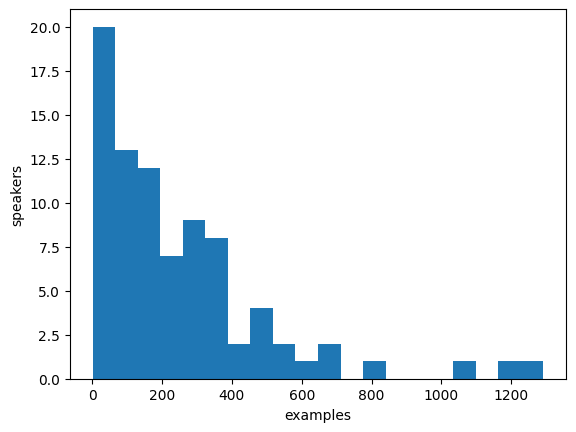

In [ ]:
plt.hist(speaker_counts.values(), bins=20);
plt.ylabel('speakers');
plt.xlabel('examples');

In [ ]:
def select_speaker(speaker_id):
    return  100 <= speaker_counts[speaker_id] <= 400

In [ ]:
dataset = dataset.filter(select_speaker, input_columns=['speaker_id'])
len(dataset)

Loading cached processed dataset at /root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-83a50e4e959e220b.arrow


9973

In [ ]:
import os
import torch
import speechbrain
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier

In [ ]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

In [ ]:
def create_speaker_embedding(waveform):
  with torch.no_grad():
    spkr_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
    spkr_embeddings = torch.nn.functional.normalize(spkr_embeddings, dim=2)
    spkr_embeddings = spkr_embeddings.squeeze().cpu().numpy()
  return spkr_embeddings

In [ ]:
def prepare_dataset(example):
  audio = example['audio']

  example = processor(
      text = example['normalized_text'],
      audio_target=audio['array'],
      sampling_rate=audio['sampling_rate'],
      return_attention_mask=False
  )

  example['labels'] = example['labels'][0]
  example['speaker_embeddings'] = create_speaker_embedding(audio['array'])

  return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example['speaker_embeddings'].shape

(512,)

In [ ]:
processed_example['labels'].shape

(345, 80)

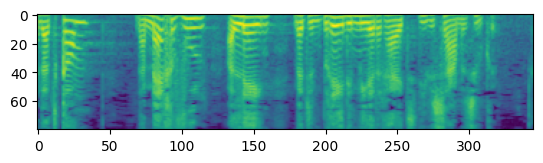

In [ ]:
plt.imshow(processed_example['labels'].T);

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

  0%|          | 0/9973 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


In [ ]:
def is_not_too_long(input_ids):
  input_length = len(input_ids)
  return input_length < 200

In [ ]:
dataset = dataset.filter(is_not_too_long, input_columns=['input_ids'])
len(dataset)

  0%|          | 0/9 [00:00<?, ?ba/s]

8259

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="carl_speecht5_finetuned_voxpopuli_nl",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["wandb"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
    dataloader_num_workers=1,
    dataloader_prefetch_factor=1,
    
)

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


In [ ]:
trainer.push_to_hub()